# Setup

## Imports

In [1]:
using Pkg
Pkg.activate("SCC", shared=true)

import QuantumToolbox as qt
import SuperconductingCavities as SC
import CairoMakie as cm
using Revise
using Dates
import JSON3

using YAXArrays

using ProgressMeter

import Optim as opt

using Logging
using MiniLoggers

using IJulia
if isdefined(Main, :IJulia)
   Main.IJulia.stdio_bytes[] = 0;
end


  Activating project at `~/.julia/environments/SCC`
┌ Info: new driver key :netcdf, updating backendlist.
└ @ NetCDFExt /Users/gavinrockwood/.julia/packages/YAXArrayBase/M48vP/ext/NetCDFExt.jl:110


0

## Logger Setups

In [2]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(18) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

In [99]:
Mode3 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode3/Mode3.json");

In [300]:
length(Mode3.dressed_states[(0,0)])

100

# Looking at Quasienergies

In [289]:
Mode3.Stuff["Chirp Params"]["fn_gn+1"][2]

15-element Vector{Any}:
 0.001
 0.07235714285714286
 0.1437142857142857
 0.21507142857142855
 0.2864285714285714
 0.3577857142857143
 0.4291428571428571
 0.5005
 0.5718571428571428
 0.6432142857142857
 0.7145714285714286
 0.7859285714285714
 0.8572857142857142
 0.9286428571428572
 1

In [274]:
Δf(ε) = sum([Mode3.Stuff["Chirp Params"]["fn_gn+1"][1]["param"][n]*ε^n for n in 1:length(Mode3.Stuff["Chirp Params"]["fn_gn+1"][1]["param"])])

Δf (generic function with 1 method)

In [272]:
Δf(1)

6.757584248521838e-5

In [220]:
dat = open_dataset("Data/Quasienergies_Tue-Jan-7-25_00_05.nc")

YAXArray Dataset
Shared Axes: 
  (↓ state Categorical{String} [(7, 1), (0, 3), …, (9, 0), (6, 7)] Unordered,
  → eps   Sampled{Float64} 0.7:0.004522613065326633:1.6 ForwardOrdered Regular Points,
  ↗ shift Sampled{Float64} 0.03:0.0008542713567839196:0.2 ForwardOrdered Regular Points)

Variables: 
layer



In [306]:
dat.cubes[:layer].axes

(↓ state Categorical{String} [(7, 1), (0, 3), …, (9, 0), (6, 7)] Unordered,
→ eps   Sampled{Float64} 0.7:0.004522613065326633:1.6 ForwardOrdered Regular Points,
↗ shift Sampled{Float64} 0.03:0.0008542713567839196:0.2 ForwardOrdered Regular Points)

In [227]:
println(fieldnames(typeof(dat.cubes[:layer][eps = At(0.7), state = At(string((7,1))), shift = At(0.03)])))
dat.cubes[:layer][eps = At(0.7), state = At(string((7,1))), shift = At(0.03)][1]

(:axes, :data, :properties, :chunks, :cleaner)


-8.85782366032715

In [228]:
stark_shifts = (dat.axes[:shift]);
states = (dat.axes[:state]);
eps = (dat.axes[:eps]);

In [234]:
state1 = (2,0)
state2 = (0,1)

y1 = collect(dat.cubes[:layer][state= At(string(state1))].data)./pi
y2 = collect(dat.cubes[:layer][state= At(string(state2))].data)./pi

for i in 1:length(stark_shifts)
    ν = abs(Mode3.Stuff["op_drive_params"]["sb_f0g1"]["freq_d"] + stark_shifts[i])
    y1[i,:] = [y1[i, j] >= 0 ? y1[i,j] : 2*ν - y1[i,j] for j in 1:length(y1[i,:])]
    y2[i,:] = [y2[i, j] >= 0 ? y2[i,j] : 2*ν - y2[i,j] for j in 1:length(y2[i,:])]
end
abs_difs1 = abs.(y1-y2)
abs_difs2 = -abs.(y1-y2)

for i in 1:length(stark_shifts)
    ν = abs(Mode3.Stuff["op_drive_params"]["sb_f0g1"]["freq_d"] + stark_shifts[i])
    abs_difs2[i,:] .= abs.(abs_difs2[i,:].+2*ν)
end

abs_difs = min.(abs_difs1, abs_difs2);
# plot_data = Array{Float64, 2}(undef, length(stark_shifts), length(states))
# for i in 1:length(stark_shifts) 
#     x = abs_difs[i, :]
#     x2 = 2*abs((Mode3.Stuff["op_drive_params"]["sb_f0g1"]["freq_d"]+stark_shifts[i])) .- x

#     abs_difs[i, :] .= min.(x, x2)
# end

200×200 Matrix{Float64}:
 0.0103397  0.00879401  0.0073694   …  0.344336  0.346117  0.347897
 0.0111621  0.00957593  0.00808467     0.343651  0.345432  0.347213
 0.0120032  0.0103844   0.00884085     0.34296   0.344743  0.346525
 0.0128607  0.0112151   0.00963009     0.342266  0.344049  0.345832
 0.0137327  0.012065    0.0104466      0.341566  0.34335   0.345134
 0.0146179  0.0129317   0.011286    …  0.340862  0.342647  0.344432
 0.0155152  0.0138133   0.0121449      0.340153  0.341939  0.343725
 0.0164237  0.0147082   0.013021       0.33944   0.341227  0.343014
 0.0173427  0.0156155   0.0139122      0.338722  0.34051   0.342298
 0.0182716  0.0165341   0.0148171      0.337999  0.339788  0.341577
 ⋮                                  ⋱                      
 0.299527   1.66075     0.295005       0.127795  0.12989   0.13198
 0.301441   1.69543     0.296901       0.126303  0.128396  0.130488
 0.303329   1.73017     0.298759       0.124808  0.126902  0.128997
 0.305169   1.76495     0.300537

In [258]:
Δf.(collect(eps.val))

200-element Vector{Vector{Float64}}:
 [1.6530840845959305e-7, 0.0008789127439127011, 0.0034651565616274456, 0.007752286306458366, 0.013727152872505114, 0.021363653319538222, 0.030610172108435016, 0.041412123029850034, 0.05378815881333739, 0.06768884435690177, 0.08294005301899533, 0.09958565754572254, 0.11754956586446749, 0.13663402010456754, 0.15692996188355007]
 [1.688412987481758e-7, 0.0008976964363238452, 0.003539212189402633, 0.007917964370034265, 0.014020522856071423, 0.021820226848039005, 0.03126435770480877, 0.04229716262732163, 0.054937692982126106, 0.06913545716445499, 0.08471260718351607, 0.10171395341224167, 0.12006177757553242, 0.1395540954184342, 0.16028379211815408]
 [1.7247510012702636e-7, 0.0009170166534288328, 0.0036153830920742456, 0.008088374749833782, 0.014322272461555008, 0.02228984163420276, 0.03193722901638318, 0.043207481897643445, 0.056120061667924166, 0.07062339004245514, 0.08653579138709536, 0.1039030404833439, 0.12264574640386938, 0.14255757778984196, 0.1637

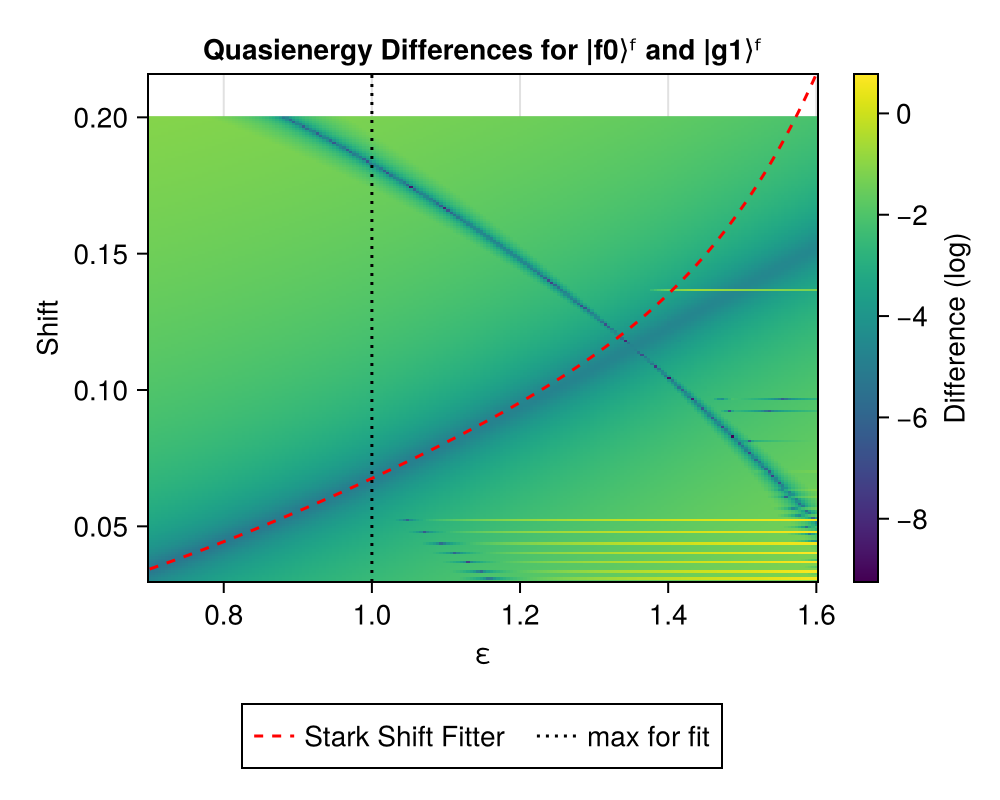

CairoMakie.Screen{IMAGE}


In [292]:
fig = cm.Figure(size = (500,400))
ax = cm.Axis(fig[1,1], xlabel = "ε", ylabel = "Shift", title = "Quasienergy Differences for |f0⟩ᶠ and |g1⟩ᶠ")

to_plot = log.(abs_difs)
cm.heatmap!(ax, collect(eps.val), collect(stark_shifts), to_plot)
cm.lines!(collect(eps.val), Δf.(collect(eps.val)), color = "red", label = "Stark Shift Fitter", linestyle = :dash)
cm.vlines!(1, color = "black", linestyle = :dot, label = "max for fit")

cm.Colorbar(fig[1,2], limits = [minimum(to_plot), maximum(to_plot)], label = "Difference (log)")
cm.Legend(fig[2,1], ax, orientation = :horizontal)



display(fig)